In [1]:
import os
from urllib.request import urlretrieve

import open3d as o3d
from core.deep_global_registration import DeepGlobalRegistration
from config_constant import get_config

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/fmorisato/.local/lib/python3.9/site-packages/MinkowskiEngine/__init__.py:36: UserWarning: The environment variable `OMP_NUM_THREADS` not set. MinkowskiEngine will automatically set `OMP_NUM_THREADS=16`. If you want to set `OMP_NUM_THREADS` manually, please export it on the command line before running a python script. e.g. `export OMP_NUM_THREADS=12; python your_program.py`. It is recommended to set it below 24.
  warnings.warn(


In [2]:
BASE_URL = "http://node2.chrischoy.org/data/"
DOWNLOAD_LIST = [
    (BASE_URL + "datasets/registration/", "redkitchen_000.ply"),
    (BASE_URL + "datasets/registration/", "redkitchen_010.ply"),
    (BASE_URL + "projects/DGR/", "ResUNetBN2C-feat32-3dmatch-v0.05.pth")
]

# Check if the weights and file exist and download
if not os.path.isfile('redkitchen_000.ply'):
    print('Downloading weights and pointcloud files...')
    for f in DOWNLOAD_LIST:
        print(f"Downloading {f}")
        urlretrieve(f[0] + f[1], f[1])

In [2]:
import copy
import numpy as np
import pandas as pd
from pathlib import Path
import json
from scipy.spatial import cKDTree
from tqdm import tqdm
import torch
from structured_plot import Figure, Subplot, plot_action as pa
import dataclasses

In [3]:
def save_as_json(obj, filepath):
    with open(filepath, "w") as f:
        json.dump(obj, f, indent=2)

def access_7f_observed_data_resolver(dirname):
    base = "/mnt/h/fumipo/investigate-open3d/internal_only_data/2022-05-09_akihabara_observed"
    dirpath = base + "/" + dirname
    return lambda filename: dirpath + "/" + filename

@dataclasses.dataclass
class RegistrationAnswerConfig:
    Tref: np.ndarray
    bbox_center: np.ndarray
    bbox_radius: float
    
    @staticmethod
    def load(path):
        with open(path, "r") as f:
            conf = json.load(f)
            return AutoCropConfig(
                np.array(conf["Tref"]), 
                np.array(conf["bbox_center"]),
                conf["bbox_radius"],
            )
        
    def dump(self, jsonpath):
        obj = {
            "Tref": [list(r) for r in self.Tref],
            "bbox_center": list(self.bbox_center),
            "bbox_radius": self.bbox_radius,
        }
        with open(jsonpath, "w") as f:
            json.dump(obj, f, indent=2) 
    

In [4]:
def _make_circle(center, radius):
    return [
        [radius * np.cos(t / 180 * np.pi) + center[0], radius * np.sin(t / 180 * np.pi) + center[1], 0] for t in np.arange(0, 360, 10)
    ]

def crop_pcd_by_cylinder(pcd, center, radius):
    crop = o3d.visualization.SelectionPolygonVolume()
    crop.orthogonal_axis = "z"
    crop.axis_min = -10
    crop.axis_max = 10
    crop.bounding_polygon = o3d.utility.Vector3dVector(np.array(_make_circle(center, radius)))
    return crop.crop_point_cloud(pcd)

def registration_as_reference(source, target, voxel_size, bbox_center, bbox_radius):
    source_down = source.voxel_down_sample(voxel_size)
    target_down = target.voxel_down_sample(voxel_size)
    
    # Registration with subset of the target pointcloud to increase success rate
    target_subset = crop_pcd_by_cylinder(target, bbox_center, bbox_radius)
    target_down_subset = crop_pcd_by_cylinder(target_down, bbox_center, bbox_radius)
    
    source_down.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=1, max_nn=100))
    target_down_subset.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=1, max_nn=100))
    target_subset.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=1, max_nn=100))

    # This is reference, so we use fixed parameters
    gr_params = dict(
        radius_normal=1, radius_feature=5, max_nn_normal=100, max_nn_feature=500, distance_threshold=voxel_size * 2
    )
    result = registration(source_down, target_down_subset, **gr_params)
    return result, source_down, target_down, target_down_subset, target_subset

In [5]:
def _pcd2xyz(pcd):
    return np.asarray(pcd.points).T

def _find_knn_cpu(array0, array1, knn=1, return_distance=False):
    """
    array0: [[0, 0, 0],[1, 0, 0],...]
    array1: [[0, 0, 0],[0, 0, 1],...]
    
    array0 の各行に対し、
    knn=1 => [[0], [1], [2], ...]: array1 のうち最も距離が近い点の index を返す
    knn=2 => [[0, 16], [1, 7], [2, 4], ...]: array1 のうち最も距離が近い2点の index からなる配列の組を返す
    
    return_distance=True のとき、
    knn=1 => ([[0], [1], [2], ...], [[0.1], [0.1], [0.2], ...]): array1 のうち最も距離が近い点のindexと距離を返す
    knn=2 => ([[0, 16], [1, 7], [2, 4], ...], [[0.1, 0.16], [0.1, 0.7], [0.2, 0.4], ...]):
        array1 のうち最も距離が近い2点のindexからなる配列と、距離からなる配列の組を返す
    """
    array1tree = cKDTree(array1)
    dists, nn_inds = array1tree.query(array0, k=knn, workers=-1)
    if knn == 1:
        dists = np.array([dists]).T
        nn_inds = np.array([nn_inds]).T

    if return_distance:
        return nn_inds, dists
    else:
        return nn_inds
    
def _find_correspondences(array0, array1, knn=1, mutual_filter=True):
    """
    array0: [[0, 0, 0],[1, 0, 0],...]
    array1: [[0, 0, 0],[0, 0, 1],...]
    
    Returns 3 arrays
    - corres_idx0: array of index of the points of the source point cloud
        e.g. [[1], [2], [4], ...]
        
    - corres_idx1: array of indices of the points of the target point cloud,
        corresponding to the source points
        e.g. 
            - knn = 1: [[344], [445], [2], ...]
            - knn = 2: [[344, 566], [445, 12], [2, 22], ...]
    - distances
    """
    
    nns01, dist01 = _find_knn_cpu(array0, array1, knn=knn, return_distance=True)
    corres01_idx0 = np.arange(len(nns01))
    corres01_idx1 = nns01

    if not mutual_filter:
        return np.array([corres01_idx0]).T, corres01_idx1, dist01

    nns10 = _find_knn_cpu(array1, array0, knn=knn, return_distance=False)
    corres10_idx1 = np.arange(len(nns10))
    corres10_idx0 = nns10

    mutual_filter = (corres10_idx0[corres01_idx1[:,0], 0] == corres01_idx0)
    corres_idx0 = corres01_idx0[mutual_filter]
    corres_idx1 = corres01_idx1[mutual_filter]
    corres_dist = dist01[mutual_filter]

    return np.array([corres_idx0]).T, corres_idx1, corres_dist

def preprocess(pcd, dgr):
    points_down, coords0, feats0 = dgr.preprocess(pcd)
    feats = dgr.fcgf_feature_extraction(feats0, coords0)
    
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points_down)
    
    return pcd, feats.cpu().detach().numpy()
    

def extract_correspondence_FCGF_set(source, target, dgr, mutual_filter=False):
    source_down, coords0, feats0 = dgr.preprocess(source)
    target_down, coords1, feats1 = dgr.preprocess(target)

    # Step 1: Feature extraction
    fcgf_feats0 = dgr.fcgf_feature_extraction(feats0, coords0)
    fcgf_feats1 = dgr.fcgf_feature_extraction(feats1, coords1)

    corres_0_idx, corres_1_idx, dist = _find_correspondences(fcgf_feats0.cpu().detach().numpy(), fcgf_feats1.cpu().detach().numpy(), knn=1, mutual_filter=mutual_filter)
   
    return corres_0_idx, corres_1_idx, dist


def validate_correspondence_by_distance(corres_indices, distances, threshold):
    """
    Update indices whose distance are larger than the threshold to -1
    (integer type array cannot contain np.nan)
    """
    corres_indices[distances >= threshold] = -1
    return corres_indices

def validate_correspondence_feature_by_distance(source, target, Tref, dgr, source_corres_indices, target_corres_indices, threshold):
    points0, _, _ = dgr.preprocess(source)
    points1, _, _ = dgr.preprocess(target)
    source = o3d.geometry.PointCloud()
    source.points = o3d.utility.Vector3dVector(points0)
    source.transform(Tref)
    points0 = np.asarray(source.points)
    
    source_corres_points = points0[source_corres_indices.T[0]]
    target_corres_points = points1[target_corres_indices.T[0]].numpy()
    feature_point_distances = np.linalg.norm(source_corres_points - target_corres_points, axis=1)
    return feature_point_distances < threshold, feature_point_distances
    

def paint_outlier_of_correspondence(pcd, validated_indices):
    pcd = copy.deepcopy(pcd)
    pcd.colors = o3d.utility.Vector3dVector(np.array(
        [[1, 0, 0] if i[0] < 0 else [0, 0, 0] for i in validated_indices]
    ))
    return pcd

In [6]:
def make_open3d_point_cloud(xyz, color=None):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(xyz)
    if color is not None:
        pcd.colors = o3d.utility.Vector3dVector(color)
    return pcd

def _valid_feat_ratio(pcd0, pcd1, feat0, feat1, trans_gth, thresh=0.1):
    pcd0_copy = copy.deepcopy(pcd0)
    pcd0_copy.transform(trans_gth)
    inds = _find_knn_cpu(feat0, feat1, return_distance=False)
    dist = np.linalg.norm((np.asarray(pcd0_copy.points) - np.asarray(pcd1.points)[inds[:, 0]]), axis=1)
    return np.mean(dist < thresh)

def _evaluate_feature_3dmatch(pcd0, pcd1, feat0, feat1, trans_gth, inlier_thresh=0.1):
    r"""Return the hit ratio (ratio of inlier correspondences and all correspondences).

    inliear_thresh is the inlier_threshold in meter.
    """
    if len(pcd0.points) < len(pcd1.points):
        hit = _valid_feat_ratio(pcd0, pcd1, feat0, feat1, trans_gth, inlier_thresh)
    else:
        hit = _valid_feat_ratio(pcd1, pcd0, feat1, feat0, np.linalg.inv(trans_gth), inlier_thresh)
    return hit

def validate_correspondence_FCGF_by_distance(source, target, dgr, Tref, tau_1=0.1, num_rand_keypoints=-1):
    # This method is basically the same one as scripts/benchmark_3dmatch.py in the FCGF GitHub repository: 
    #   https://github.com/chrischoy/FCGF/blob/master/scripts/benchmark_3dmatch.py .
    #
    # The feature match recall ratio obtained by this function is almost same as 
    #   our function validate_correspondence_feature_by_distance invoked with mutual_filter=False.
    # So it is not necessary for us to use this function...
    
    points_i, coord_i, feats0 = dgr.preprocess(source)
    points_j, coord_j, feats1 = dgr.preprocess(target)

    # Step 1: Feature extraction
    feat_i = dgr.fcgf_feature_extraction(feats0, coord_i).detach().cpu().numpy()
    feat_j = dgr.fcgf_feature_extraction(feats1, coord_j).detach().cpu().numpy()

    coord_i = make_open3d_point_cloud(points_i)
    coord_j = make_open3d_point_cloud(points_j)
    hit_ratio = _evaluate_feature_3dmatch(coord_i, coord_j, feat_i, feat_j, Tref, tau_1)
    return hit_ratio

In [7]:
def draw_correspondence_sets(
    source, target, Tref, dgr, distance_threshold, translate=[0, 0, 0], mutual_filter=False, colors=None):
    """
    2つの点群の特徴点の対応関係を可視化する
    
    sourceの特徴点と最も似ているtargetの特徴点の間を緑の直線で結ぶ。
    """
    yellow = [1, 0.706, 0]
    blue = [0, 0.651, 0.929]
    
    points0, _, _ = dgr.preprocess(source)
    points1, _, _ = dgr.preprocess(target)
    source_view = o3d.geometry.PointCloud()
    source_view.points = o3d.utility.Vector3dVector(points0)
    source_view.transform(Tref).translate(translate)
    target_view = o3d.geometry.PointCloud()
    target_view.points = o3d.utility.Vector3dVector(points1)
    
    view_pcd = o3d.geometry.PointCloud()
    view_pcd.points =  o3d.utility.Vector3dVector(np.concatenate((np.asarray(source_view.points), points1), axis=0))
    if colors is not None:
        view_pcd.colors = o3d.utility.Vector3dVector(colors)
    
    _source = copy.deepcopy(source).transform(Tref).translate(translate).paint_uniform_color(yellow)
    _target = copy.deepcopy(target).paint_uniform_color(blue)
    
    self_corres_idx, feature_corres_idx, _ = extract_correspondence_FCGF_set(source, target, dgr, mutual_filter=mutual_filter)
    valid_correspondence, _ = validate_correspondence_feature_by_distance(source, target, Tref, dgr, self_corres_idx, feature_corres_idx, distance_threshold)
    
    self_inlier_idx = self_corres_idx[valid_correspondence]
    self_outlier_idx = self_corres_idx[~valid_correspondence]
    inlier_idx = feature_corres_idx[valid_correspondence]
    outlier_idx = feature_corres_idx[~valid_correspondence]
    
    
    def create_line_set(source, target, corres_source, corres_target, color_as_rgb_array):
        num_corrs = len(corres_source)
        points = np.concatenate((np.asarray(source.points)[corres_source], np.asarray(target.points)[corres_target]),axis=0)
        translated_points = []
        lines = []
        colors = []
        for i in range(num_corrs):
            lines.append([i,i+num_corrs])
            dist = np.linalg.norm(points[i] - points[i + num_corrs])
            colors.append([])
        colors = [color_as_rgb_array for i in range(len(lines))] # lines are shown in green
        
        line_set = o3d.geometry.LineSet(
            points=o3d.utility.Vector3dVector(points),
            lines=o3d.utility.Vector2iVector(lines),
        )
        line_set.colors = o3d.utility.Vector3dVector(colors)
        return line_set
        
    
    green = [0, 1, 0]
    red = [1, 0, 0]
    
    if len(self_inlier_idx.shape) == 1:
        nearest_lines_inlier = []
    else: 
        nearest_lines_inlier = [create_line_set(source_view, target_view, self_inlier_idx[:, 0], inlier_idx[:, 0], green)]
    
    nearest_lines_outlier = [create_line_set(source_view, target_view, self_outlier_idx[:, 0], outlier_idx[:, 0], red)]
    
    o3d.visualization.draw_geometries(
        [view_pcd]
         + nearest_lines_inlier + nearest_lines_outlier 
    )
    torch.cuda.empty_cache()

def evaluate_successful_feature_correspondence(source, target, Tref, dgr, distance_threshold, mutual_filter=False):
    self_corres_idx, feature_corres_idx, _ = extract_correspondence_FCGF_set(source, target, dgr, mutual_filter)
    valid_correspondence, _ = validate_correspondence_feature_by_distance(source, target, Tref, dgr, self_corres_idx, feature_corres_idx, distance_threshold)
    self_inlier_idx = self_corres_idx[valid_correspondence]
    self_outlier_idx = self_corres_idx[~valid_correspondence]
    
    torch.cuda.empty_cache()
    return {
        "source_voxel_count": len(source.points),
        "target_voxel_count": len(target.points),
        "correspondence_count": len(feature_corres_idx),
        "successful_correspondence_ratio": np.mean(valid_correspondence)
    }

In [8]:
config = get_config(dict(voxel_size=0.01))
if config.weights is None:
    config.weights = "./ResUNetBN2C-feat32-3dmatch-v0.05.pth"
    dgr = DeepGlobalRegistration(config)
    dgr.network_config.nn_max_n = 5 # Reduce GPU memory allocation error
    dgr.voxel_size = 0.05



=> loading checkpoint './ResUNetBN2C-feat32-3dmatch-v0.05.pth'
./ResUNetBN2C-feat32-3dmatch-v0.05.pth
=> Setting voxel size to 0.05
=> loading finished


In [34]:
# ファミレス席 optimized
data_resolver = access_7f_observed_data_resolver("result_20220509_104225")

source = o3d.io.read_point_cloud(data_resolver("pointcloud.ply"))
target = o3d.io.read_point_cloud("/mnt/h/fumipo/investigate-open3d/internal_only_data/2022-04-18_filter_less_feature_parts/manualy_filterd_point_cloud/access_7F_noise_reduced.ply")

answer = RegistrationAnswerConfig.load(data_resolver("registration_answer.json"))
    
source.estimate_normals()
target_subset = crop_pcd_by_cylinder(target, answer.bbox_center, answer.bbox_radius)
target_subset.estimate_normals()

AutoCropConfig(Tref=array([[ 9.49739847e-01,  1.14215300e-02, -3.12831858e-01,
        -4.15828957e+00],
       [-3.12687363e-01, -1.28270923e-02, -9.49769487e-01,
        -2.55637682e+01],
       [-1.48605438e-02,  9.99852496e-01, -8.61103263e-03,
        -1.16293487e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]]), bbox_center=array([ -5.55853224, -23.76529503]), bbox_radius=3)


In [100]:
# red kitchen
source = o3d.io.read_point_cloud("./redkitchen_000.ply")
target = o3d.io.read_point_cloud("./redkitchen_010.ply")
Tref = np.array([[ 0.99972507,  0.0197497,   0.01263899, -0.70825555],
 [-0.02043753,  0.99817468,  0.05682936,  0.18280789],
 [-0.01149356, -0.05707205,  0.99830387, -0.18115155],
 [ 0.        ,  0.       ,   0.        ,  1.        ],])

bbox_center = [0, 0]

source.estimate_normals()
target_subset = crop_pcd_by_cylinder(target, bbox_center, 10)
target_subset.estimate_normals()

In [103]:
validate_correspondence_FCGF_by_distance(source, target, dgr, Tref, tau_1=0.1, num_rand_keypoints=-1)

0.2950718685831622

In [32]:
# Sofa
data_resolver = access_7f_observed_data_resolver("result_20220509_104047")

source = o3d.io.read_point_cloud(data_resolver("pointcloud.ply"))
target = o3d.io.read_point_cloud("/mnt/h/fumipo/investigate-open3d/internal_only_data/2022-04-18_filter_less_feature_parts/manualy_filterd_point_cloud/access_7F_noise_reduced.ply")

answer = RegistrationAnswerConfig.load(data_resolver("registration_answer.json"))
    
source.estimate_normals()
target_subset = crop_pcd_by_cylinder(target, answer.bbox_center, answer.bbox_radius)
target_subset.estimate_normals()

In [31]:
# Sofa optimized
data_resolver = access_7f_observed_data_resolver("result_20220509_104100")

source = o3d.io.read_point_cloud(data_resolver("pointcloud_optimized.ply"))
target = o3d.io.read_point_cloud("/mnt/h/fumipo/investigate-open3d/internal_only_data/2022-04-18_filter_less_feature_parts/manualy_filterd_point_cloud/access_7F_noise_reduced.ply")

answer = RegistrationAnswerConfig.load(data_resolver("registration_answer.json"))

source.estimate_normals()
target_subset = crop_pcd_by_cylinder(target, answer.bbox_center, answer.bbox_radius)
target_subset.estimate_normals()

In [7]:
source.estimate_normals()
target_subset = crop_pcd_by_cylinder(target, bbox_center, 10)
target_subset.estimate_normals()

In [89]:
source = o3d.io.read_point_cloud("./redkitchen_000.ply")
target = o3d.io.read_point_cloud("./redkitchen_010.ply")

Tref = np.array(
[[ 0.99972507,  0.0197497 ,  0.01263899, -0.70825555],
 [-0.02043753,  0.99817468,  0.05682936,  0.18280789],
 [-0.01149356, -0.05707205,  0.99830387, -0.18115155],
 [ 0.        ,  0.        ,  0.        ,  1.        ],]
)
bbox_center = [0, 0]

source.estimate_normals()
target_subset = crop_pcd_by_cylinder(target, bbox_center, 3)
target_subset.estimate_normals()

In [12]:
draw_correspondence_sets(source, target_subset, Tref, dgr, 0.1, [-2, -2, 3], True)
torch.cuda.empty_cache()

In [104]:
evaluate_successful_feature_correspondence(source, target_subset, Tref, dgr, 0.1, True)

{'source_voxel_count': 258342,
 'target_voxel_count': 277550,
 'correspondence_count': 347,
 'successful_correspondence_ratio': 0.5734870317002881}

In [14]:
torch.cuda.empty_cache()
np.mean(dgr.extract_feature(source, target_subset)[2].cpu().detach().numpy())

1.0

In [9]:
def evaluate_FCGF_successful_pair(source, target, radiuses, Tref, bbox_center, dgr, distance_threshold):
    results = []
    for radius in tqdm(radiuses):
        source.estimate_normals()
    
        target_subset = crop_pcd_by_cylinder(target, bbox_center, radius)
        target_subset.estimate_normals()
        res = evaluate_successful_feature_correspondence(source, target_subset, Tref, dgr, distance_threshold)
        extra_info = dict(
            radius=radius
        )
        results.append(res | extra_info)
        torch.cuda.empty_cache()
    return results


import matplotlib.ticker as ticker

def plot_ratio(result_df):
    fig, axes = Figure().add_subplot(
        Subplot().add(
            data=result_df,
            x="radius",
            y="successful_correspondence_ratio",
            xlabel="crop radius",
            ylabel="ratio",
            ylim=[0, 0.5],
            plot=[
                pa.line(),
                pa.set_grid(axis="y")
            ],
        ),
        Subplot().add(
            data=result_df,
            x="target_voxel_count",
            y="successful_correspondence_ratio",
            xlabel="target voxel count",
            ylabel="ratio",
            ylim=[0, 0.5],
            plot=[
                pa.line(),
                pa.set_grid(axis="y")
            ],
        )
    ).show(size=(8, 6), column=2)
    
    for ax in axes.values():
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))

In [14]:
source = o3d.io.read_point_cloud("/mnt/h/fumipo/investigate-open3d/internal_only_data/2022-04-18_filter_less_feature_parts/20220418_map4_observer1/20220418_004428_tmpqrb2yrgd.ply")
Tref = np.array([[ 9.49739847e-01,  1.14215300e-02, -3.12831858e-01, -4.15828957e+00],
 [-3.12687363e-01, -1.28270923e-02, -9.49769487e-01, -2.55637682e+01],
 [-1.48605438e-02,  9.99852496e-01, -8.61103263e-03, -1.16293487e-01],
 [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, 1.00000000e+00]])
bbox_center = [-5.55853224, -23.76529503]

radiuses = np.arange(0.5, 35, 0.5)

result = evaluate_FCGF_successful_pair(source, target, radiuses, Tref, bbox_center, dgr, 1)
result_df = pd.DataFrame.from_records(result)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 69/69 [1:39:05<00:00, 86.17s/it]


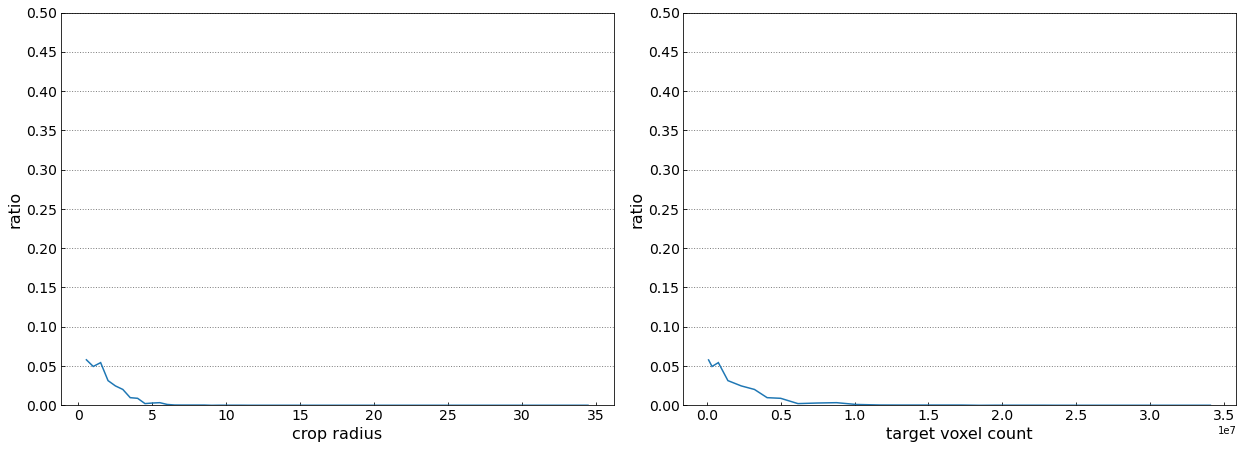

In [15]:
plot_ratio(result_df)

## 特徴量分布可視化

In [9]:
import umap
from scipy.sparse.csgraph import connected_components

from sklearn.cluster import DBSCAN
import matplotlib
from matplotlib import cm

In [10]:
def convert_by_umap(fpfh, n_neighbors=15, min_dist=0.1, n_components=3):
    u_map = umap.UMAP(n_neighbors=n_neighbors, n_components=n_components, min_dist=min_dist, random_state=0)
    X_reduced_map = u_map.fit_transform(fpfh)
    return X_reduced_map

def with_continuous_cmap(cmap):
    def apply(values, vmin=None, vmax=None):
        vmin = vmin or np.min(values)
        vmax = vmax or np.max(values)
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
        return cmap(norm(values))
    return apply

def get_cluster_colors(feature, eps=0.5, min_samples=10, cmap=cm.tab10):
    db = DBSCAN(eps=eps, min_samples=min_samples).fit(feature)
    labels = db.labels_
    print(f"Number of clusters is {len(np.unique(labels)) - 1}")
    
    colors = cmap(labels)
    colors[labels==-1] = np.array([0, 0, 0, 1])
    return colors

def get_scalar_space_colors(feat, cmap, umap_params):
    umapped = convert_by_umap(feat, **(umap_params|{"n_components": 1}))
    colors = with_continuous_cmap(cmap)(umapped)
    return umapped, colors[:, 0]

def plot_cluster(feature, colors):
    if feature.shape[1] > 2:
        subplot = Subplot().add(
            data=None,
            x=feature[:, 0],
            y=feature[:, 1],
            xlabel="Feature 1",
            ylabel="Feature 2",
            plot=pa.scatter(c=colors),
        )
    else:
         subplot = Subplot().add(
            data=None,
            x=feature[:, 0],
            y=[np.random.uniform(-1, 1) for _ in feature[:, 0]],
            xlabel="Feature 1",
            ylabel="Feature 2",
            plot=pa.scatter(c=colors),
        )
        
    Figure().add_subplot(
        subplot
    ).show(size=(10, 10))
    
def paint_pcd_by_cluster(pcd, colors):
    cluster_color = o3d.utility.Vector3dVector(colors[:, 0:3])
    pcd.normals = o3d.utility.Vector3dVector([])
    
    clustered = copy.deepcopy(pcd)
    clustered.colors = cluster_color
    return clustered

In [11]:
def umap_with_merged_pcd(source, target, dgr, umap_params):
    s_pcd_down, s_fcgf = preprocess(source, dgr)

    t_pcd_down, t_fcgf = preprocess(target, dgr)
    
    pcd_merged_down = o3d.geometry.PointCloud()
    pcd_merged_down.points = o3d.utility.Vector3dVector(np.concatenate((s_pcd_down.points, copy.deepcopy(t_pcd_down).translate((2.5, 0, -1)).points), axis=0))
    pcd_merged_down.colors = o3d.utility.Vector3dVector(np.concatenate((s_pcd_down.colors, copy.deepcopy(t_pcd_down).translate((2.5, 0, -1)).colors), axis=0))

    merged_fcgf = np.concatenate((s_fcgf, t_fcgf), axis = 0)
    merged_fcgf_umap = convert_by_umap(merged_fcgf, **umap_params)
    
    return pcd_merged_down, merged_fcgf, merged_fcgf_umap

def merged_fcgf(source, target, dgr):
    s_pcd_down, s_fcgf = preprocess(source, dgr)

    t_pcd_down, t_fcgf = preprocess(target, dgr)
    
    pcd_merged_down = o3d.geometry.PointCloud()
    pcd_merged_down.points = o3d.utility.Vector3dVector(np.concatenate((s_pcd_down.points, copy.deepcopy(t_pcd_down).translate((2.5, 0, -1)).points), axis=0))
    pcd_merged_down.colors = o3d.utility.Vector3dVector(np.concatenate((s_pcd_down.colors, copy.deepcopy(t_pcd_down).translate((2.5, 0, -1)).colors), axis=0))
    
    merged_fcgf = np.concatenate((s_fcgf, t_fcgf), axis = 0)
    return pcd_merged_down, merged_fcgf

In [34]:
source_down, source_fcgf = preprocess(source, dgr)

(PointCloud with 15850 points.,
 array([[ 0.35231003, -0.09372468, -0.01167804, ..., -0.19516675,
          0.04252967,  0.24184474],
        [ 0.1532869 , -0.1717172 ,  0.02521981, ..., -0.21469611,
         -0.07804653,  0.30846587],
        [ 0.32997134, -0.1558193 , -0.0586406 , ..., -0.2078054 ,
          0.01947963,  0.21919961],
        ...,
        [ 0.1610351 , -0.17335504,  0.02913626, ..., -0.2665423 ,
         -0.04306366,  0.29963827],
        [ 0.2136859 , -0.15938355, -0.10605391, ..., -0.27060595,
          0.06486847,  0.3111668 ],
        [ 0.19257712, -0.16521394, -0.13768233, ..., -0.25212297,
         -0.00800416,  0.27421534]], dtype=float32))

In [85]:
umap_params = dict(
    n_neighbors=10,
    min_dist=0.1,
    n_components=3
)

s_umap = convert_by_umap(source_fcgf, **umap_params)

Number of clusters is 101


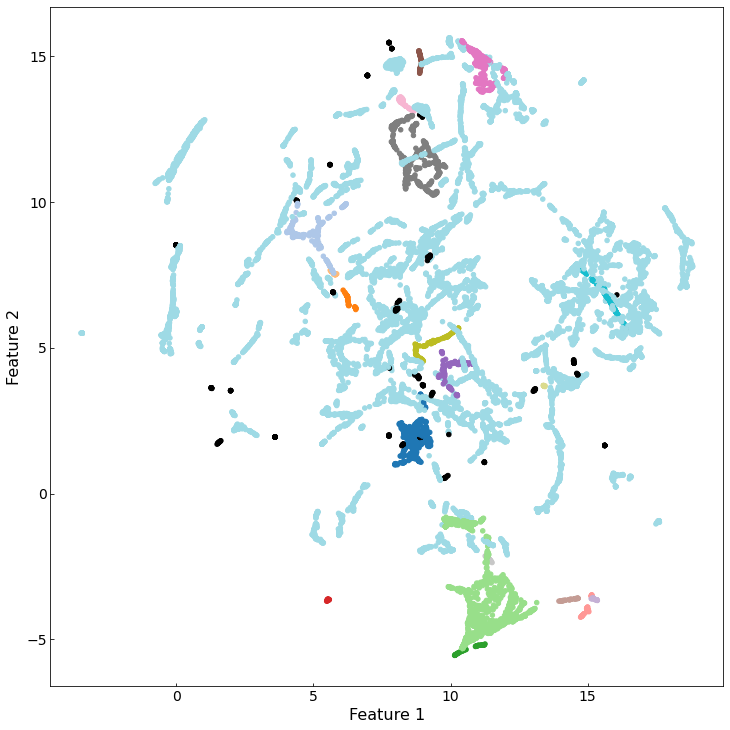

In [86]:
colors = get_cluster_colors(s_umap, eps=0.5, min_samples=20, cmap=cm.tab20)
plot_cluster(s_umap, colors)

In [87]:
o3d.visualization.draw_geometries([
    paint_pcd_by_cluster(source_down, colors)
])

In [37]:
umap_params = dict(
    n_neighbors=10,
    min_dist=0.1,
    n_components=1
)

s_umap = convert_by_umap(source_fcgf, **umap_params)

In [83]:
colors[:, 0][:, 0:3]

array([[0.26286591, 1.        , 0.        ],
       [0.        , 0.50257594, 1.        ],
       [0.26286591, 1.        , 0.        ],
       ...,
       [0.        , 1.        , 0.33933883],
       [0.30918949, 1.        , 0.        ],
       [0.30918949, 1.        , 0.        ]])

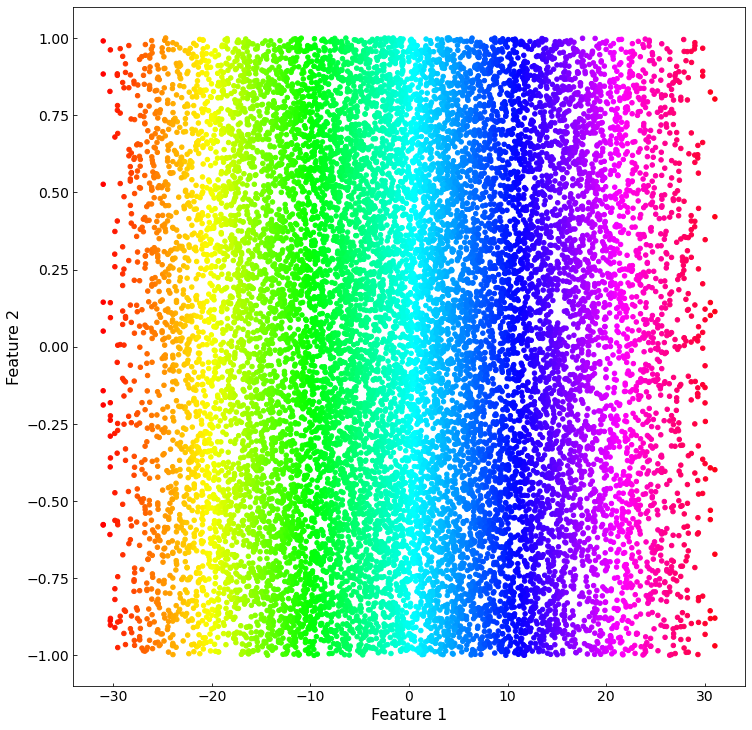

In [88]:
umapped, colors = get_scalar_space_colors(s_umap, cm.hsv, umap_params)
plot_cluster(umapped, colors)

In [27]:
del target
torch.cuda.empty_cache()

In [13]:
o3d.visualization.draw_geometries([
    paint_pcd_by_cluster(merged_pcd, colors)
])

NameError: name 'colors' is not defined

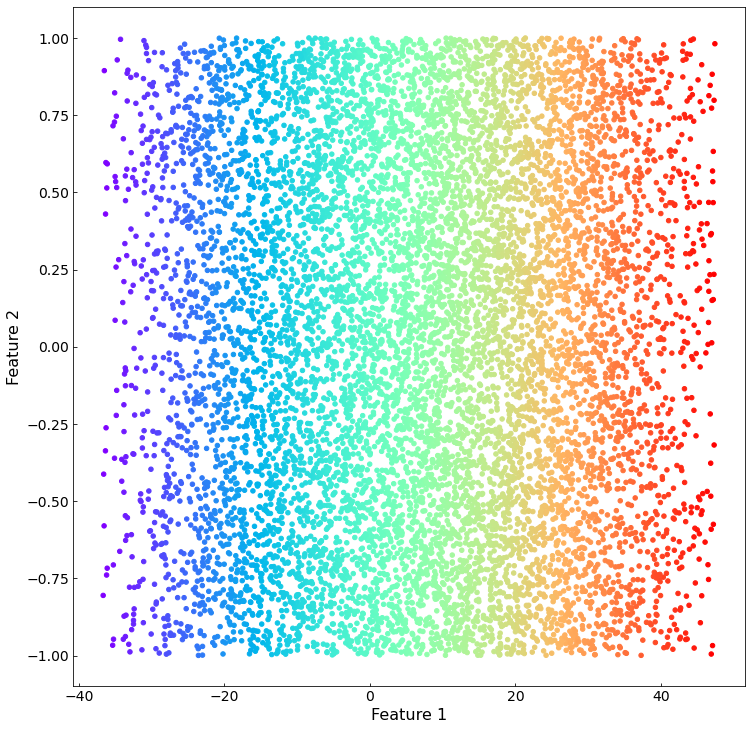

In [18]:
umap_params = dict(
    n_neighbors=20,
    min_dist=1.,
    n_components=1
)

merged_pcd, merged_feat = merged_fcgf(source, target_subset, dgr)
umapped, colors = get_scalar_space_colors(merged_feat, cm.rainbow, umap_params)
plot_cluster(umapped, colors)

In [22]:
o3d.visualization.draw_geometries([
    paint_pcd_by_cluster(merged_pcd, colors)
])

In [20]:
draw_correspondence_sets(source, target_subset, Tref, dgr, 0.1, [-0, -3, -0], True, colors[:, :3])

In [21]:
evaluate_successful_feature_correspondence(source, target_subset, Tref, dgr, 0.1, True)

{'source_voxel_count': 258342,
 'target_voxel_count': 277550,
 'correspondence_count': 347,
 'successful_correspondence_ratio': 0.5734870317002881}